In [71]:
import torch
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score, classification_report, accuracy_score, confusion_matrix
import tensorflow as tf

In [16]:
df = pd.read_csv('./../Naive_Bayes/tweets/allLabeledTweets.csv')
df.head()

,message,id,tweetId,createdAt,language,inReplyToStatusId,inReplyToUserId,inReplyToScreenName,userId,userName,...,retweetedId,retweetCount,label,message_lowercase,clean_message,clean_message_no_punct,clean_message_no_stopwords_from_list,clean_message_no_punct_no_stopwords_from_list,clean_message_no_punct_no_freq_stopwords,clean_message_no_freq_stopwords
0,"Rodas sajūta, ka arī @airBaltic ir kaut kāds @...",0,1213615462581440500,2020-01-05T00:17:28+00:00,lv,NaN,NaN,NaN,62004316,Edgars Eglītis,...,NaN,0,2,"rodas sajūta, ka arī @airbaltic ir kaut kāds @...","rodas sajūta, ka arī MENTION ir kaut kāds MENT...",rodas sajūta ka arī MENTION ir kaut kāds MENT...,"rodas sajūta , MENTION kāds MENTION kaktu kant...",rodas sajūta MENTION kāds MENTION kaktu kantor...,rodas sajūta MENTION kaut MENTION kaktu kantor...,"rodas sajūta , MENTION kaut MENTION kaktu kant..."
1,"Amsterdama, @airBaltic smukulītes 👍🏻 https://...",0,1213740889476128800,2020-01-05T08:35:52+00:00,lv,NaN,NaN,NaN,213752948,Dairis Kuciks,...,NaN,0,1,"amsterdama, @airbaltic smukulītes 👍🏻 https://...","amsterdama, MENTION smukulītes 👍🏻 URL",amsterdama MENTION smukulītes 👍🏻 URL,"amsterdama , MENTION smukulītes 👍🏻 URL",amsterdama MENTION smukulītes 👍🏻 URL,amsterdama MENTION smukulītes 👍🏻 URL,"amsterdama , MENTION smukulītes 👍🏻 URL"
2,Kārtējo reizi... \r\n@airBaltic vakar raudošai...,0,1214174186069012500,2020-01-06T13:17:38+00:00,lv,NaN,NaN,NaN,1107743410646069200,Selma,...,NaN,73,2,kārtējo reizi... \r\n@airbaltic vakar raudošai...,kārtējo reizi... MENTION vakar raudošai sievie...,kārtējo reizi MENTION vakar raudošai sievie...,kārtējo reizi ... MENTION vakar raudošai sievi...,kārtējo reizi MENTION vakar raudošai sievietei...,kārtējo reizi MENTION vakar raudošai sievietei...,kārtējo reizi ... MENTION vakar raudošai sievi...
3,80.05% airBaltic akciju pieder Latvijas valsti...,0,1214176732456075300,2020-01-06T13:27:45+00:00,lv,NaN,NaN,NaN,1107743410646069200,Selma,...,NaN,2,2,80.05% airbaltic akciju pieder latvijas valsti...,NMBR % airbaltic akciju pieder latvijas valsti...,NMBR airbaltic akciju pieder latvijas valsti...,NMBR % airbaltic akciju pieder latvijas valsti...,NMBR airbaltic akciju pieder latvijas valstij ...,NMBR airbaltic akciju pieder latvijas valstij ...,NMBR % airbaltic akciju pieder latvijas valsti...
4,Laba ideja lidojumiem ar @airBaltic https://t....,0,1214197047382941700,2020-01-06T14:48:29+00:00,lv,NaN,NaN,NaN,110783755,Inga Gorbunova,...,NaN,4,0,laba ideja lidojumiem ar @airbaltic https://t....,laba ideja lidojumiem ar MENTION URL,laba ideja lidojumiem ar MENTION URL,laba ideja lidojumiem MENTION URL,laba ideja lidojumiem MENTION URL,laba ideja lidojumiem MENTION URL,laba ideja lidojumiem MENTION URL


In [17]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=0.15, 
                                                  random_state=42, 
                                                  stratify=df.label.values)

df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

df.groupby(['label', 'data_type']).count()

message   id  tweetId  createdAt  language  \
label data_type                                               
0     train          205  205      205        205       205   
      val             37   37       37         37        37   
1     train           71   71       71         71        71   
      val             13   13       13         13        13   
2     train          103  103      103        103       103   
      val             18   18       18         18        18   

                 inReplyToStatusId  inReplyToUserId  inReplyToScreenName  \
label data_type                                                            
0     train                      0                0                    0   
      val                        0                0                    0   
1     train                      0                0                    0   
      val                        0                0                    0   
2     train                      0                0                    0   
      val                        0                0                    0   

                 userId  userName  ...  placeType  retweetedId  retweetCount  \
label data_type                    ...                                         
0     train         205       205  ...          9            0           205   
      val            37        37  ...          0            0            37   
1     train          71        71  ...          5            0            71   
      val            13        13  ...          4            0            13   
2     train         103       103  ...         10            0           103   
      val            18        18  ...          0            0            18   

                 message_lowercase  clean_message  clean_message_no_punct  \
label data_type                                                             
0     train                    205            205                     205   
      val                       37             37                      37   
1     train                     71             71                      71   
      val                       13             13                      13   
2     train                    103            103                     103   
      val                       18             18                      18   

                 clean_message_no_stopwords_from_list  \
label data_type                                         
0     train                                       205   
      val                                          37   
1     train                                        71   
      val                                          13   
2     train                                       103   
      val                                          18   

                 clean_message_no_punct_no_stopwords_from_list  \
label data_type                                                  
0     train                                                205   
      val                                                   37   
1     train                                                 71   
      val                                                   13   
2     train                                                103   
      val                                                   18   

                 clean_message_no_punct_no_freq_stopwords  \
label data_type                                             
0     train                                           205   
      val                                              37   
1     train                                            71   
      val                                              13   
2     train                                           103   
      val                                              18   

                 clean_message_no_freq_stopwords  
label data_type                                   
0     train                                  205  
      val        

In [20]:
df.groupby(['label', 'data_type']).count()

message   id  tweetId  createdAt  language  \
label data_type                                               
0     train          205  205      205        205       205   
      val             37   37       37         37        37   
1     train           71   71       71         71        71   
      val             13   13       13         13        13   
2     train          103  103      103        103       103   
      val             18   18       18         18        18   

                 inReplyToStatusId  inReplyToUserId  inReplyToScreenName  \
label data_type                                                            
0     train                      0                0                    0   
      val                        0                0                    0   
1     train                      0                0                    0   
      val                        0                0                    0   
2     train                      0                0                    0   
      val                        0                0                    0   

                 userId  userName  ...  placeType  retweetedId  retweetCount  \
label data_type                    ...                                         
0     train         205       205  ...          9            0           205   
      val            37        37  ...          0            0            37   
1     train          71        71  ...          5            0            71   
      val            13        13  ...          4            0            13   
2     train         103       103  ...         10            0           103   
      val            18        18  ...          0            0            18   

                 message_lowercase  clean_message  clean_message_no_punct  \
label data_type                                                             
0     train                    205            205                     205   
      val                       37             37                      37   
1     train                     71             71                      71   
      val                       13             13                      13   
2     train                    103            103                     103   
      val                       18             18                      18   

                 clean_message_no_stopwords_from_list  \
label data_type                                         
0     train                                       205   
      val                                          37   
1     train                                        71   
      val                                          13   
2     train                                       103   
      val                                          18   

                 clean_message_no_punct_no_stopwords_from_list  \
label data_type                                                  
0     train                                                205   
      val                                                   37   
1     train                                                 71   
      val                                                   13   
2     train                                                103   
      val                                                   18   

                 clean_message_no_punct_no_freq_stopwords  \
label data_type                                             
0     train                                           205   
      val                                              37   
1     train                                            71   
      val                                              13   
2     train                                           103   
      val                                              18   

                 clean_message_no_freq_stopwords  
label data_type                                   
0     train                                  205  
      val        

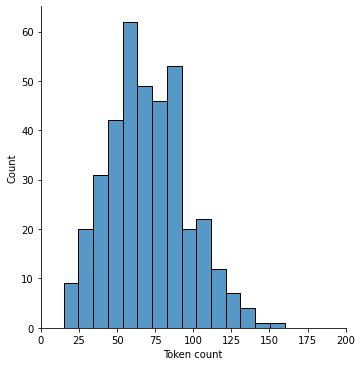

In [29]:
# Find max length for tokenizer
token_lens = []
for txt in list(df[df.data_type=='train'].message.values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    
sns.displot(token_lens)
plt.xlim([0, 200])
plt.xlabel('Token count')
plt.show()

#165

In [30]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)

In [31]:
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].message.values, 
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_attention_mask=True, 
    padding='max_length', 
    max_length=165, 
    truncation=True,
    return_tensors='pt' # Return PyTorch tensors
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].message.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    padding='max_length', 
    max_length=165, 
    truncation=True,
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

len(dataset_train), len(dataset_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\aligo\Documents\DEV\twitter-lv-market\venv38\lib\site-packages\transformers\tokenization_utils_base.py:2212: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


(379, 68)

In [ ]:
dataset_train

In [32]:
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased",
                                                      num_labels=3,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [33]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 3

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [34]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)

In [35]:
epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(dataloader_train)*epochs)

In [38]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [39]:
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [43]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cpu


In [113]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [47]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'models7/finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.8318500121630082
Validation loss: 0.8297346802833288
F1 Score (Weighted): 0.6548345709731347


Epoch 2:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.687879205366054
Validation loss: 0.7412645181883937
F1 Score (Weighted): 0.7194852941176472


Epoch 3:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.5003164832839581
Validation loss: 0.9010133057751734
F1 Score (Weighted): 0.6970735662686127


Epoch 4:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.3564117879966113
Validation loss: 1.025445687746548
F1 Score (Weighted): 0.6880736618971913


Epoch 5:   0%|          | 0/127 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.26737557249657046
Validation loss: 1.0686793172853473
F1 Score (Weighted): 0.7058823529411765


In [49]:
# Evaluate
model.load_state_dict(torch.load('models7/finetuned_BERT_epoch_2.model', map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(dataloader_validation)

In [53]:
print(predictions)
print(true_vals)

[[ 0.8858358   0.14105213 -0.513066  ]
 [-1.6035718  -0.48101157  1.3492693 ]
 [ 3.164962   -1.0567942  -1.5544996 ]
 [-0.32793224 -0.03681315  0.41687918]
 [ 0.3376204   0.66205615 -0.63059354]
 [ 0.63508046  0.5287831  -0.79365593]
 [ 0.41032517  0.72027165 -0.6245356 ]
 [ 0.06367293  0.625394   -0.4108181 ]
 [ 3.112114   -1.1128235  -1.621546  ]
 [ 3.1621695  -1.1352627  -1.5408473 ]
 [-1.0181398  -0.3259492   0.7194981 ]
 [ 2.7567148  -1.013685   -1.2819393 ]
 [-1.6487277  -0.49759245  1.5455343 ]
 [-1.2877803  -0.56269956  1.39223   ]
 [ 3.129787   -1.065842   -1.6121141 ]
 [ 3.1347623  -1.1690668  -1.6202205 ]
 [ 3.1587276  -1.1816691  -1.5806907 ]
 [ 3.1788003  -1.1569557  -1.5854945 ]
 [ 3.178621   -1.1501609  -1.5686334 ]
 [ 3.1200252  -1.0546885  -1.6150074 ]
 [ 3.08359    -1.188403   -1.5352881 ]
 [ 0.45625094 -0.10132962  0.03260231]
 [ 0.4523208   0.08580122 -0.06870622]
 [-0.9743455  -0.19785765  0.45859066]
 [-0.71022975  0.02929774  0.36701196]
 [-0.74669856 -0.41597712

In [57]:
preds_flat = np.argmax(predictions, axis=1).flatten()
print(preds_flat)

[0 2 0 2 1 0 1 1 0 0 2 0 2 2 0 0 0 0 0 0 0 0 0 2 2 2 0 0 0 0 0 0 0 2 0 2 2
 0 0 2 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 2 0 2 0 0 0 2 0 2 2 2 2 2]


In [58]:
print(classification_report(true_vals, preds_flat))
pd.DataFrame(confusion_matrix(true_vals, preds_flat),
        index = [['actual', 'actual', 'actual'], ['neutral', 'positive', 'negative']],
        columns = [['predicted', 'predicted', 'predicted'], ['neutral', 'positive', 'negative']])

              precision    recall  f1-score   support

           0       0.79      0.92      0.85        37
           1       1.00      0.23      0.38        13
           2       0.64      0.78      0.70        18

    accuracy                           0.75        68
   macro avg       0.81      0.64      0.64        68
weighted avg       0.79      0.75      0.72        68



predicted                  
                  neutral positive negative
actual neutral         34        0        3
       positive         5        3        5
       negative         4        0       14

In [59]:
from transformers import TextClassificationPipeline

# test_pred = model.predict(X_test)
# print(test_pred)

pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True)

In [61]:
res = pipe(["I love this movie!", "I hate this movie!"])
print(res)

[[{'label': 'LABEL_0', 'score': 0.4163522720336914}, {'label': 'LABEL_1', 'score': 0.3224363625049591}, {'label': 'LABEL_2', 'score': 0.2612113058567047}], [{'label': 'LABEL_0', 'score': 0.3587017357349396}, {'label': 'LABEL_1', 'score': 0.31799253821372986}, {'label': 'LABEL_2', 'score': 0.32330572605133057}]]


In [91]:
def trans_preds(res):
    all_vals = []
    for arr in res:
        vals = []
        for label_values in arr:
            vals.append(label_values['score'])
        all_vals.append(vals)

    p = np.argmax(all_vals, axis=1).flatten()
    return p

In [141]:
def print_my_examples(inputs, results):
    result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {trans_preds(results)[i]}'
                         for i in range(len(inputs))]
    print(*result_for_printing, sep='\n')
    print()
    
examples = [
    'Tā ir brīnišķīga filma',
    'Viss ir slikti',
    '❤',
    'Filma bija OK',
    'Tā filma bija briesmīga...'
]

In [142]:
results = pipe(examples)

In [143]:
print_my_examples(examples, results)

input: Tā ir brīnišķīga filma         : score: 0
input: Viss ir slikti                 : score: 2
input: ❤                              : score: 1
input: Filma bija OK                  : score: 0
input: Tā filma bija briesmīga...     : score: 2



In [100]:
inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
labels = torch.tensor([1]).unsqueeze(0)  # need dtype=float for BCEWithLogitsLoss
outputs = model(**inputs, labels=labels)
loss = outputs.loss
logits = outputs.logits
print(outputs)

SequenceClassifierOutput(loss=tensor(1.0453, grad_fn=<NllLossBackward0>), logits=tensor([[ 0.2972,  0.1839, -0.1386]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)


In [110]:
inputs = tokenizer.batch_encode_plus(
    examples, 
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_attention_mask=True, 
    padding='max_length', 
    max_length=165, 
    truncation=True,
    return_tensors='pt' # Return PyTorch tensors
)

# input_ids = inputs['input_ids']
# attention_masks = inputs['attention_mask']
# labels = torch.tensor(df[df.data_type=='val'].label.values)

# dataset_inputs = TensorDataset(inputs)

outputs = model(**inputs)

In [116]:
outputs

SequenceClassifierOutput(loss=None, logits=tensor([[ 1.1018, -0.1069, -0.3755],
        [ 0.4777,  0.0176,  0.1579],
        [ 0.9149,  0.0210, -0.1788],
        [ 0.8174,  0.1800, -0.1088],
        [-0.7169, -0.5046,  0.9797]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [120]:
logits = outputs.logits
logits = logits.detach().cpu().numpy()
logits

array([[ 1.1017747 , -0.1069112 , -0.37547195],
       [ 0.477729  ,  0.01759287,  0.15792726],
       [ 0.91488606,  0.02098612, -0.17877908],
       [ 0.8173776 ,  0.1799692 , -0.10880005],
       [-0.71693987, -0.5045896 ,  0.9797273 ]], dtype=float32)

In [122]:
pr = np.argmax(logits, axis=1).flatten()
print(pr)

[0 0 0 0 2]


In [135]:
def predict(bert_model, inputs):
    inputs = tokenizer.batch_encode_plus(
        inputs, 
        add_special_tokens=True, # Add '[CLS]' and '[SEP]'
        return_attention_mask=True, 
        padding='max_length', 
        max_length=165, 
        truncation=True,
        return_tensors='pt' # Return PyTorch tensors
    )
    outputs = bert_model(**inputs)
    
    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    
    predictions = np.argmax(logits, axis=1).flatten()
    return predictions

In [145]:
predict(model, examples)

array([0, 2, 1, 0, 2], dtype=int64)